<a href="https://www.kaggle.com/code/hossamrizk/transfer-learning?scriptVersionId=149254042" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input 

In [2]:
# Read data
train_data="/kaggle/input/alien-vs-predator-images/data/train/"
validation_data="/kaggle/input/alien-vs-predator-images/data/validation/"

In [3]:
classes_train=os.listdir(train_data)
classes_test=os.listdir(validation_data)

In [4]:
print(classes_train)

['predator', 'alien']


In [5]:
print(classes_test)

['predator', 'alien']


# Data augmentation

In [6]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    rescale=1.0/255.0,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data,
    batch_size=32,
    class_mode='binary',
    target_size=(224,224))


test_datagen=ImageDataGenerator(
    rescale=1.0/255.0
)
test_generator=test_datagen.flow_from_directory(
    validation_data,
    class_mode='binary',
    color_mode='rgb',
    batch_size=32,
    target_size=(224,224)
)

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# Create the network

In [7]:
pre_model=ResNet50(include_top=False,
                   weights='imagenet'
                  )
for layer in pre_model.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [8]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from keras import Model
y= pre_model.output
y= GlobalAveragePooling2D()(y)
y= Dense(256, activation='relu')(y) 
predictions = Dense(2, activation='softmax')(y)
model = Model(pre_model.input, predictions)

In [9]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Fit

In [11]:
model.fit_generator(
    train_generator, 
    epochs=15,
    validation_data=test_generator 
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
22/22 [==============================] - 24s 656ms/step - loss: 0.7853 - accuracy: 0.4856 - val_loss: 0.6513 - val_accuracy: 0.5350
Epoch 2/15
22/22 [==============================] - 10s 473ms/step - loss: 0.6525 - accuracy: 0.6081 - val_loss: 0.6220 - val_accuracy: 0.6800
Epoch 3/15
22/22 [==============================] - 10s 473ms/step - loss: 0.6386 - accuracy: 0.6484 - val_loss: 0.6436 - val_accuracy: 0.6000
Epoch 4/15
22/22 [==============================] - 10s 471ms/step - loss: 0.6089 - accuracy: 0.6758 - val_loss: 0.6099 - val_accuracy: 0.6650
Epoch 5/15
22/22 [==============================] - 11s 476ms/step - loss: 0.6038 - accuracy: 0.6599 - val_loss: 0.6009 - val_accuracy: 0.6950
Epoch 6/15
22/22 [==============================] - 10s 474ms/step - loss: 0.6113 - accuracy: 0.6671 - val_loss: 0.5976 - val_accuracy: 0.6950
Epoch 7/15
22/22 [==============================] - 10s 471ms/step - loss: 0.6393 - accuracy: 0.6239 - val_loss: 0.9671 - val_accuracy: 0.5000

In [12]:
losses = pd.DataFrame(model.history.history)

In [13]:
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,0.785259,0.485591,0.651342,0.535
1,0.652506,0.608069,0.622025,0.680
2,0.638641,0.648415,0.643590,0.600
3,0.608857,0.675793,0.609857,0.665
4,0.603811,0.659942,0.600851,0.695


<AxesSubplot:>

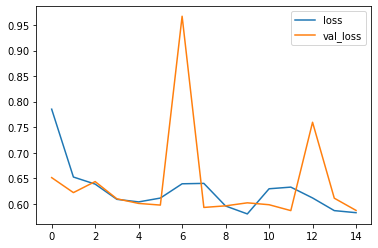

In [14]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

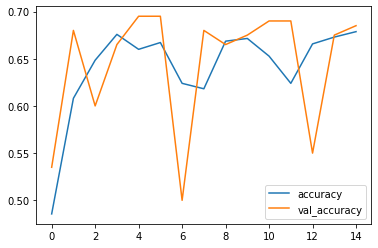

In [15]:
losses[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

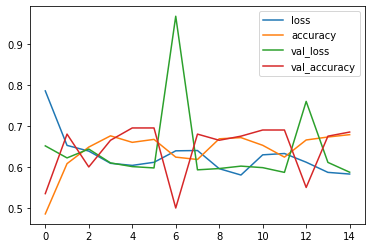

In [16]:
losses.plot()

In [17]:
model.evaluate(test_generator)

7/7 [==============================] - 1s 70ms/step - loss: 0.5872 - accuracy: 0.6850


[0.5871682167053223, 0.6850000023841858]

In [18]:
class_names = ['alien','predator']

In [19]:
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    images, labels = generator.next()
    predictions = np.argmax(model.predict(images), axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

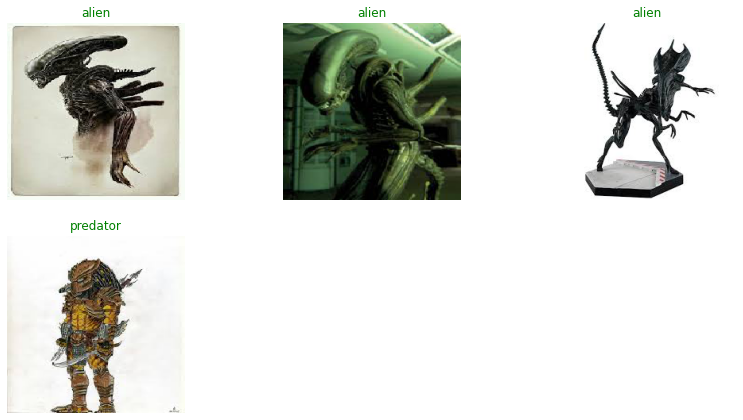

In [20]:
plot_prediction(test_generator,5)